In [1]:
#with Hyperparameter tuning with GridSearchCV

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from category_encoders import LeaveOneOutEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore")

df = pd.read_csv("cleaned.csv") 
print("Dataset loaded successfully:", df.shape)


Dataset loaded successfully: (25443, 11)


In [2]:
# Define categorical and numerical features
categorical_cols = ['Crop_Type', 'Soil_Type']
numerical_cols = ['Soil_pH', 'Soil_Quality', 'N', 'P', 'K',
                  'Wind_Speed', 'Temperature', 'Humidity']
target_col = 'Crop_Yield'

# Define features and target
X = df[categorical_cols + numerical_cols]
y = df[target_col]

# Ensure categorical features are strings
X[categorical_cols] = X[categorical_cols].astype(str).fillna("Unknown")


In [3]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (20354, 10), Test shape: (5089, 10)


In [4]:
rf_pipeline = Pipeline([
    ('encoder', LeaveOneOutEncoder(cols=categorical_cols, sigma=0.05)),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
])

In [5]:
# hyperparameter grid

param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [10, 20, None],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2],
    'model__max_features': ['sqrt']
}

In [6]:
# Hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    cv=3,               # 3-fold cross-validation
    n_jobs=-1,
    verbose=2,
    scoring='r2'
)

print("\n🚀 Performing hyperparameter tuning...")
grid_search.fit(X_train, y_train)

print("\n✅ Best Parameters Found:")
print(grid_search.best_params_)
print("Best Cross-Validation R²:", grid_search.best_score_)



🚀 Performing hyperparameter tuning...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

✅ Best Parameters Found:
{'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Best Cross-Validation R²: 0.9556259544908531


In [7]:
# Evaluation
best_model = grid_search.best_estimator_

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)


In [8]:
# Calculate metrics
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

In [9]:
print("\n Tuned Random Forest Performance (LOO Encoding)")
print(f"Training → R²: {train_r2:.6f}, RMSE: {train_rmse:.6f}, MAE: {train_mae:.6f}")
print(f"Testing  → R²: {test_r2:.6f}, RMSE: {test_rmse:.6f}, MAE: {test_mae:.6f}")



 Tuned Random Forest Performance (LOO Encoding)
Training → R²: 0.972221, RMSE: 3.719593, MAE: 2.580672
Testing  → R²: 0.956908, RMSE: 4.667657, MAE: 3.331247


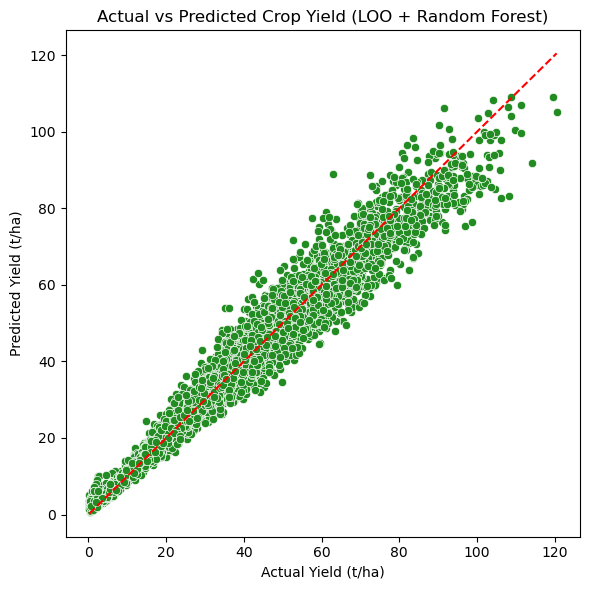

In [10]:
# Vizualization

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_test_pred, color='forestgreen')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Actual vs Predicted Crop Yield (LOO + Random Forest)")
plt.xlabel("Actual Yield (t/ha)")
plt.ylabel("Predicted Yield (t/ha)")
plt.tight_layout()
plt.show()

In [11]:

joblib.dump(best_model, "SavedModel.pkl")
print("\n Tuned model saved as 'SavedModel.pkl'")

feature_order = X_train.columns.tolist()
joblib.dump(feature_order, "feature_order.pkl")
print("Feature order saved as 'feature_order.pkl'")



 Tuned model saved as 'SavedModel.pkl'
Feature order saved as 'feature_order.pkl'


In [12]:
# Load model and feature order
model = joblib.load("SavedModel.pkl")
feature_order = joblib.load("feature_order.pkl")


In [13]:
new_crop_data = {
    'Crop_Type': 'Wheat',
    'Soil_Type': 'Loamy',
    'Soil_pH': 6.7,
    'Soil_Quality': 75,
    'N': 42,
    'P': 36,
    'K': 22,
    'Wind_Speed': 11.5,
    'Temperature': 29.8,
    'Humidity': 73.2,
}


In [14]:
# Prepare data for prediction
new_df = pd.DataFrame([new_crop_data])
new_df = new_df[feature_order]  # ensure correct column order

# Predict
predicted_yield = model.predict(new_df)[0]
print(f"\n Predicted Crop Yield: {predicted_yield:.3f} tonnes/hectare")


 Predicted Crop Yield: 39.792 tonnes/hectare


In [17]:
new_crop_data = {
        'Crop_Type': 'Cotton',
        'Soil_Type': 'Clay',
        'Soil_pH': 6.25,
        'Soil_Quality': 49.29,
        'N': 66,
        'P': 55,
        'K': 48,
        'Wind_Speed': 3.67,
        'Temperature': 19.54,
        'Humidity': 80
    }

new_df = pd.DataFrame([new_crop_data])
new_df = new_df[feature_order]  # ensure correct column order

# Predict
predicted_yield = model.predict(new_df)[0]
print(f"\n Predicted Crop Yield: {predicted_yield:.3f} tonnes/hectare")


 Predicted Crop Yield: 75.047 tonnes/hectare


In [30]:
new_crop_data = {
    'Crop_Type': 'Barley',
    'Soil_Type': 'Sandy',
    'Soil_pH': 6.75,
    'Soil_Quality': 35,
    'N': 50, 'P': 40, 'K': 30,
    'Wind_Speed': 2.68,
    'Temperature': 19.75,
    'Humidity': 80.00
}
new_df = pd.DataFrame([new_crop_data])
new_df = new_df[feature_order]  # ensure correct column order

# Predict
predicted_yield = model.predict(new_df)[0]
print(f"\n Predicted Crop Yield: {predicted_yield:.3f} tonnes/hectare")


 Predicted Crop Yield: 55.140 tonnes/hectare


In [22]:
df

,Crop_Type,Soil_Type,Soil_pH,Temperature,Humidity,Wind_Speed,N,P,K,Crop_Yield,Soil_Quality
0,Corn,Loamy,6.50,20.052576,79.947424,8.591577,84.0,66.0,50.0,104.871310,66.666667
1,Barley,Sandy,6.75,19.751848,80.000000,2.682683,50.0,40.0,30.0,58.939796,35.000000
2,Soybean,Peaty,5.50,16.110395,80.000000,7.696070,49.5,45.0,38.5,32.970413,22.166667
3,Cotton,Sandy,6.75,14.826739,80.000000,10.366657,55.0,44.0,36.0,29.356115,39.375000
4,Tomato,Clay,6.25,18.323272,80.000000,8.198084,60.0,45.0,40.0,22.221375,42.291667
...,...,...,...,...,...,...,...,...,...,...,...
25438,Barley,Clay,6.25,11.617771,80.000000,14.700485,60.0,50.0,40.0,13.069169,43.750000
25439,Cotton,Clay,6.25,19.538555,80.000000,3.666664,66.0,55.0,48.0,73.323885,49.291667
25440,Sugarcane,Peaty,5.50,21.068336,78.931664,8.795036,71.5,54.0,42.0,39.226521,27.916667
25441,Potato,Peaty,5.50,11.079561,80.000000,10.969366,60.5,45.0,31.5,6.067881,22.833333


In [27]:
new_crop_data = {
    'Crop_Type': 'Potato',
    'Soil_Type': 'Peaty',
    'Soil_pH': 5.5,
    'Soil_Quality': 22.83,
    'N': 60.5, 'P': 45, 'K': 31.5,
    'Wind_Speed': 10.97,
    'Temperature': 11.08,
    'Humidity': 80.00
}

In [28]:
new_df = pd.DataFrame([new_crop_data])
new_df = new_df[feature_order]  # ensure correct column order

# Predict
predicted_yield = model.predict(new_df)[0]
print(f"\n Predicted Crop Yield: {predicted_yield:.3f} tonnes/hectare")


 Predicted Crop Yield: 6.172 tonnes/hectare
